In [5]:
#With NumExpr

from time import time
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
import blosc2


def calculate_chunksize2(size):
    chunksize = size * 1024 // 8
    return chunksize


def calculate_time2(ntotal, chunksize, dtype):
    a = np.linspace(0, 10, num=ntotal,
                    dtype=dtype)  ##I create an array that will have a number of elements with a value between 0 and 10
    b = np.linspace(0, 10, num=ntotal, dtype=dtype)
    d2 = np.empty(ntotal, dtype=dtype)
    entradas = ["aa", "bb", "cc"]
    t0 = time()
    for pi in range(0, ntotal, chunksize):
        i = pi + chunksize
        views = [a[pi:i], b[pi:i]]
        dicc = dict(zip(entradas, views))
        expr = "aa**3 +3*aa**2 + 2*aa*bb + bb "  #Expressions do not accept operands, I have to tell it to access the dicc
        d2[pi: i] = ne.evaluate(expr, local_dict=dicc)
    t1 = time() - t0
    return t1


block_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]  # Varying block sizes(kilobytes)
execution_times1 = []
dtype = np.float64
ntotal = (256 * (10 ** 6)) // 8
for size in block_sizes:
    size_bytes = calculate_chunksize2(size)
    execution_times1.append(1 / calculate_time2(ntotal, size_bytes, dtype))


In [6]:
#With Filler


def calculate_chunksize2(size):
    chunksize = size * 1024 // 8
    return chunksize


def calculate_time2(ntotal, chunksize, dtype): 
    
    a = np.linspace(0, 10, num=ntotal, dtype=dtype)  ##I create an array that will have a number of elements with a value between 0 and 10
    b = np.linspace(0, 10, num=ntotal, dtype=dtype)
    schunk_dtype = np.dtype(dtype)
    typesize = schunk_dtype.itemsize
    cparams = {
        "nthreads": 1,
        "typesize": typesize,
    }
    storage = {
        "cparams": cparams,
    }

    chunk_len = 10_000 #number of elements that the chunk will have
    #chunksize is the number of bytes
    schunk = blosc2.SChunk(chunksize=chunk_len * typesize, **storage)

    #We create the filler function
    tt = time()
    @schunk.filler(((a, dtype),(b,dtype),), schunk_dtype)
    def filler(inputs_tuple, output, offset):
        output[:] = inputs_tuple[0] ** 3 + 3 * inputs_tuple[0] ** 2 + 2 * inputs_tuple[0] * inputs_tuple[1] + inputs_tuple[1]
    t2 = time() - tt
    out = np.empty(ntotal, dtype=dtype)
    schunk.get_slice(out=out)
    return t2
    
block_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]  # Varying block sizes(kilobytes)
execution_times2 = []
dtype = np.float64
ntotal = (256 * (10 ** 6)) // 8
for size in block_sizes:
    size_bytes = calculate_chunksize2(size)
    execution_times2.append(1 / calculate_time2(ntotal, size_bytes, dtype))


In [7]:
#With Blosc2

def calculate_chunksize3(size):
    chunksize = size * 1024 // 8
    return chunksize

def calculate_time3(ntotal, chunksize, dtype):
    a = blosc2.zeros(shape=ntotal, dtype=dtype)  ##I create an array that will have a number of elements with a value between 0 and 10
    b = blosc2.zeros(shape=ntotal, dtype=dtype)
    a1 = np.linspace(0, 10, num=ntotal, dtype=dtype)  ##I create an array that will have a number of elements with a value between 0 and 10
    b1 = np.linspace(0, 10, num=ntotal, dtype=dtype)
    a[:] = a1
    b[:] = b1
    d = blosc2.empty(ntotal, dtype=dtype)
    t0 = time()
    for pi in range(0, ntotal, chunksize):
        i = pi + chunksize  
        d[pi:i] = ( a[pi:i] ** 3) + 3 * (a[pi:i] ** 2) + 2 * a[pi:i] * b[pi:i] + b[pi:i]
    t3 = time() - t0
    return t3

block_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]  # Varying block sizes(kilobytes)
execution_times3 = []
dtype = np.float64
ntotal = ( 256 * (10 ** 6) ) // 8
for size in block_sizes:
    size_bytes = calculate_chunksize3(size)
    print(f"{size_bytes}")
    execution_times3.append( 1 / calculate_time3(ntotal, size_bytes, dtype) )

4096
8192
16384
32768
65536
131072
262144
524288
1048576


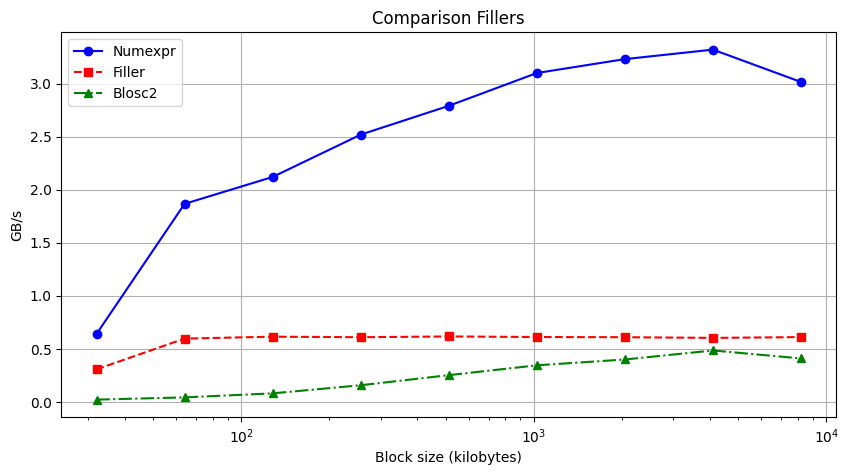

In [8]:
# Create the figure and line graph
plt.figure(figsize=(10, 5))
#Line chart 1
plt.plot(block_sizes, execution_times1, marker='o', linestyle='-', color='b', label='Numexpr')
#Line chart 2
plt.plot(block_sizes, execution_times2, marker='s', linestyle='--', color='r', label='Filler')
#Line Chart 3
plt.plot(block_sizes, execution_times3, marker='^', linestyle='-.', color='g', label='Blosc2')

# Add title and legend
plt.xscale('log')
plt.title('Comparison Fillers')
plt.xlabel('Block size (kilobytes)')
plt.ylabel('GB/s')
plt.legend()
# Show the graph
plt.grid(True)
plt.show()